## Dog vs Cat Image Classification

 ####  Start from [Check Point 1](#Check Point 1) if you want to train the nerual network based on pre-trained features using transfer learning that have been saved to disk.
 #### Start from [Check Point 2](#Check Point 2) if you want to generate predictions for test images to submit on Kaggle https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition.

In [209]:
%matplotlib inline
import cv2, os, csv
import numpy as np
import tensorflow as tf
from tensorflow_vgg import vgg16
from tensorflow_vgg import vgg19
from tensorflow_vgg import utils

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

print('All modules are imported.')

All modules are imported.


## 1. Explore the image datasets

#### Dataset statistics

In [210]:
# Image directoires
TRAIN_DIR = 'input/train/'
TEST_DIR = 'input/test/'

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

# print out statistics of the dataset and show example images
print("Stats of Dog_vs_Cat Train Dataset")
print("Total Images: {}".format(len(train_images)))
print("Dog:          {}".format(len([i for i in train_images if 'dog' in i ])))
print("Cat:          {}".format(len([i for i in train_images if 'cat' in i ])))
print('')
print('Stats of Dog_vs_Cat Test Dataset')
print('Total Images: {}'.format(len(test_images)))

Stats of Dog_vs_Cat Train Dataset
Total Images: 25000
Dog:          12500
Cat:          12500

Stats of Dog_vs_Cat Test Dataset
Total Images: 12500


#### Display Example Images

Example of Train Image: cat.2341.jpg
Image - Shape: (417, 299, 3)
Image - Min Value: 0, Max Value: 255
Label - cat


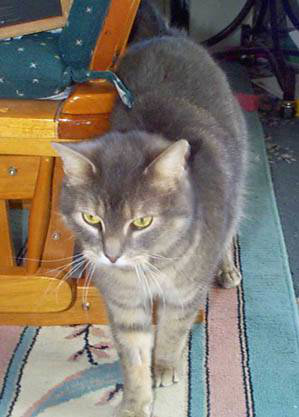

Example of Train Image: cat.1623.jpg
Image - Shape: (374, 500, 3)
Image - Min Value: 0, Max Value: 255
Label - cat


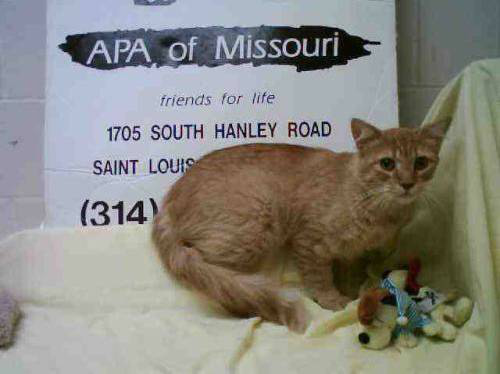

Example of Train Image: dog.6128.jpg
Image - Shape: (251, 359, 3)
Image - Min Value: 0, Max Value: 255
Label - dog


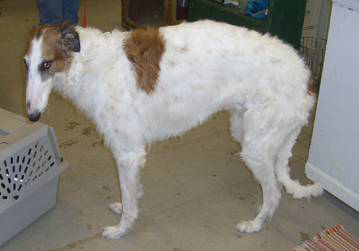

In [211]:
# Explore the dataset
image_id_list = ['cat.2341', 'cat.1623', 'dog.6128']

for image_id in image_id_list:
    image_example = cv2.imread('input/train/{}.jpg'.format(image_id), cv2.IMREAD_COLOR)
    print("Example of Train Image: {}.jpg".format(image_id))
    print("Image - Shape: {}".format(image_example.shape))
    print("Image - Min Value: {}, Max Value: {}".format(image_example.min(), image_example.max()))
    print("Label - {}".format('dog' if 'dog' in 'input/train/{}.jpg'.format(image_id) else 'cat'))
    display(Image.open('input/train/{}.jpg'.format(image_id)))

## 2. Pretrained network

Use VGGNet trained on the ImageNet dataset as a feature extractor.The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

Pretrained VGGNet
We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. The network has already been trained and the parameters are available from this link.

what we want are the values of the first fully connected layer, after being ReLUd (self.relu6).

In [ ]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 50

classes = ['cat', 'dog']

codes = None
labels = []
test_codes =  None
test_id_list = []

batch = []
with tf.Session() as sess:
    
    vgg = vgg19.Vgg19()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope('content_vgg'):
        vgg.build(input_)
        
    for each in classes:        
        print("Start preprocessing {} images".format(each))
        files = [i for i in train_images if each in i]
        for ii, file in tqdm(enumerate(files, 1), desc='{} images'.format(each), unit='Images'):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(file)
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                codes_batch = sess.run(vgg.relu6, feed_dict = {input_ : images})
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
    
    batch = []
    #Process test images  
    print("Start preprocessing test images")
    for ii, file in tqdm(enumerate(test_images, 1), desc='test images', unit='Images'):
        # Add images to the current batch
        # utils.load_image crops the input images for us, from the center
        img = utils.load_image(file)
        batch.append(img.reshape((1, 224, 224, 3)))
        test_id_list.append(int(file.split('/')[2].split('.')[0]))
            
        # Running the batch through the network to get the codes
        if ii % batch_size == 0 or ii == len(files):
                
            # Image batch to pass to VGG network
            images = np.concatenate(batch)                
            codes_batch = sess.run(vgg.relu6, feed_dict = {input_ : images})
                
            # Here I'm building an array of the codes
            if test_codes is None:
                test_codes = codes_batch
            else:
                test_codes = np.concatenate((test_codes, codes_batch))
                
            # Reset to start building the next batch
            batch = []

In [ ]:
feature_extractor = 'vgg19_relu6'

folder_name = 'transfer_learning_results/' + feature_extractor

#Creat direcotry if not exists
if not os.path.exists(folder_name):
    print('Creating new directory to save data...')
    try:
        os.makedirs(folder_name)
        print('New directory is created.')
    except Exception as e:
        print('Unable to create new directory.')
else:
    print('The directory exists.')

# Save train labels
if not os.path.isfile(folder_name +'/codes'):
    print('Saving train codes to file...')
    # write codes to file
    try:
        with open(os.path.join(folder_name, 'codes'), 'w') as f:
            codes.tofile(f)
        print('Train codes are saved to: codes')
    except Exception as e:
        print('Unable to save data to: codes')
else:
    print('Train codes are cached in file: codes')

# Save train labels
if not os.path.isfile(folder_name + '/labels'):
    print('Saving train labels to file...')
    # write labels to file
    try:
        with open(os.path.join(folder_name, 'labels'), 'w') as f:
            writer = csv.writer(f, delimiter='\n')
            writer.writerow(labels)
            print('Train Labels are saved to: labels')
    except Exception as e:
        print('Unable to save data to: labels')
else:
    print('Train Labels are cached in file: labels')

# Save test codes
if not os.path.isfile(folder_name + '/test_codes'):
    print('Saving test codes to file...')
    try:
        # write test codes to file
        with open(os.path.join(folder_name, 'test_codes'), 'w') as f:
            test_codes.tofile(f)
        print('Test codes are saved to: test_codes')
    except Exception as e:
        print('Unable to save data to: test_codes')
else:
    print('Test codes are cached in file: test_codes')

# Save test ids
if not os.path.isfile(folder_name + '/test_ids'):
    print('Saving test ids to file...')
    # write test ids to file
    try:
        with open(os.path.join(folder_name, 'test_ids'), 'w') as f:
            writer = csv.writer(f, delimiter='\n')
            writer.writerow(test_id_list)
            print('Test IDs are saved to: test_ids')
    except Exception as e:
        print('Unable to save data to: test_ids')
else:
    print('Test ids are cached in file: test_ids')

<a id='Check Point 1'></a>
## Check Point 1

If come back to this notebook or have to restart the notebook, start from here. The preprocessed data have been saved to disk.

## 3 Train the classifier

In [194]:
%matplotlib inline
import cv2, os, csv, datetime
import numpy as np
import tensorflow as tf
from tensorflow_vgg import vgg16, vgg19
from tensorflow_vgg import utils

from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit

print('All modules are imported.')

All modules are imported.


In [161]:
feature_extractor = 'vgg16_relu6'

folder_name = 'transfer_learning_results/' + feature_extractor

In [162]:
try:
    with open(os.path.join(folder_name, 'labels')) as f:
        reader = csv.reader(f, delimiter='\n')
        labels = np.array([each for each in reader if len(each) > 0]).squeeze()
    print('Train labels are reloaded from local disk.')
    print("Train labels shape:", labels.shape)
except Exception as e:
    print('Unable to reload train labels.')

try:   
    with open(os.path.join(folder_name, 'codes')) as f:
        codes = np.fromfile(f, dtype=np.float32)
        codes = codes.reshape((len(labels), -1))
    print('Train codes are reloaded from local disk.')
    print("Train codes shape:", codes.shape)

except Exception as e:
    print('Unable to reload train codes.')

Train labels are reloaded from local disk.
Train labels shape: (25000,)
Train codes are reloaded from local disk.
Train codes shape: (25000, 4096)


### One-hot encode

In [163]:
labels_vecs = [[0, 1] if 'cat' in i else [1, 0] for i in labels]
labels_vecs = np.array(labels_vecs)
print('Train Labels are one-hot coded')
print('Cat: [0, 1]')
print('Dog: [1, 0]')
print('Label shape:', labels_vecs.shape)

Train Labels are one-hot coded
Cat: [0, 1]
Dog: [1, 0]
Label shape: (25000, 2)


### Train test split

In [164]:
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.04, random_state=42)
train_idx, val_idx = next(ss.split(codes, labels_vecs))
train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]

In [165]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)

Train shapes (x, y): (24000, 4096) (24000, 2)
Validation shapes (x, y): (1000, 4096) (1000, 2)


In [173]:
def fully_conn(x_tensor, num_outputs, use_batch_norm=False, is_training=True):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    if use_batch_norm:
        weight = tf.Variable(tf.truncated_normal((x_tensor.shape[-1].value, num_outputs),
                                            stddev = 0.05))
        fc_x = tf.matmul(x_tensor, weight)
        fc_x = tf.layers.batch_normalization(fc_x,training = is_training)
        fc_x = tf.nn.relu(fc_x)
    else:
        weight = tf.Variable(tf.truncated_normal((x_tensor.shape[-1].value, num_outputs),
                                            stddev = 0.01))
        bias = tf.Variable(tf.zeros([num_outputs]))
        fc_x = tf.add(tf.matmul(x_tensor, weight), bias)
        fc_x = tf.nn.relu(fc_x)
    
    return fc_x

In [174]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weight = tf.Variable(tf.truncated_normal([x_tensor.shape[-1].value,num_outputs],
                                            stddev=0.01))
    bias = tf.Variable(tf.zeros([num_outputs]))
    return tf.add(tf.matmul(x_tensor, weight), bias)

In [175]:
##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]], name='inputs')
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]], name='y')
is_training = tf.placeholder(tf.bool, name='is_training')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

num_input = inputs_.shape[-1].value
num_output = labels_.shape[-1].value

# Model
fc = fully_conn(inputs_, 64, use_batch_norm=True, is_training=is_training)
fc = tf.nn.dropout(fc, keep_prob=keep_prob)
logits = output(fc, 2)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizaer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy, name='cost')

# Tell TensorFlow to update the population statisitcs while training
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#### Hyperparameters

In [176]:
# Tune Parameters
epochs = 20
keep_probability = 0.1

In [177]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

In [178]:
save_model_path = folder_name + '/'

iteration = 0
train_loss_iter = []
train_acc_iter = []
val_loss_iter = []
val_acc_iter = []

log_freq = 10
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for e in tqdm(range(epochs), desc='Running Epoch', unit='Epoch'):
        for x, y in get_batches(train_x, train_y):
            loss, acc, _ = sess.run([cost, accuracy, optimizer], feed_dict={inputs_: x,
                                                                            labels_: y,
                                                                            keep_prob: keep_probability,
                                                                            is_training: True})
            
            if iteration % log_freq == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={inputs_: x,
                                                                  labels_: y,
                                                                  keep_prob: 1.0,
                                                                  is_training: False})
                train_loss_iter.append(loss)
                train_acc_iter.append(acc)
                val_loss, val_acc = sess.run([cost, accuracy], feed_dict={inputs_: val_x,
                                                                          labels_: val_y,
                                                                          keep_prob: 1.0,
                                                                          is_training: False})
                val_loss_iter.append(val_loss)
                val_acc_iter.append(val_acc)
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Iteration: {}".format(iteration),
                      'Train Loss: {:.>3.5f}'.format(train_loss_iter[int(iteration/log_freq)]),
                      'Train Acc: {:.2f}%'.format(train_acc_iter[int(iteration/log_freq)]*100),
                      'Validation Loss: {:.5f}'.format(val_loss_iter[int(iteration/log_freq)]),
                      'Validation Acc: {:.2f}%'.format(val_acc_iter[int(iteration/log_freq)]*100))
            iteration += 1
    
    # Save model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Running Epoch:   0%|                                                                         | 0/20 [00:00<?, ?Epoch/s]

Epoch: 1/20 Iteration: 0 Train Loss: 0.51162 Train Acc: 77.13% Validation Loss: 0.52066 Validation Acc: 77.10%


Running Epoch:   5%|███▎                                                             | 1/20 [00:00<00:06,  2.89Epoch/s]

Epoch: 2/20 Iteration: 10 Train Loss: 0.13026 Train Acc: 97.92% Validation Loss: 0.14180 Validation Acc: 97.30%


Running Epoch:  10%|██████▌                                                          | 2/20 [00:00<00:05,  3.54Epoch/s]

Epoch: 3/20 Iteration: 20 Train Loss: 0.09745 Train Acc: 98.33% Validation Loss: 0.10754 Validation Acc: 97.70%


Running Epoch:  15%|█████████▊                                                       | 3/20 [00:00<00:04,  3.81Epoch/s]

Epoch: 4/20 Iteration: 30 Train Loss: 0.09280 Train Acc: 98.46% Validation Loss: 0.10164 Validation Acc: 98.00%


Running Epoch:  20%|█████████████                                                    | 4/20 [00:01<00:04,  3.91Epoch/s]

Epoch: 5/20 Iteration: 40 Train Loss: 0.09473 Train Acc: 98.54% Validation Loss: 0.10277 Validation Acc: 98.10%


Running Epoch:  25%|████████████████▎                                                | 5/20 [00:01<00:03,  4.01Epoch/s]

Epoch: 6/20 Iteration: 50 Train Loss: 0.08931 Train Acc: 98.58% Validation Loss: 0.09726 Validation Acc: 98.20%


Running Epoch:  30%|███████████████████▌                                             | 6/20 [00:01<00:03,  4.08Epoch/s]

Epoch: 7/20 Iteration: 60 Train Loss: 0.07600 Train Acc: 98.71% Validation Loss: 0.08456 Validation Acc: 98.10%


Running Epoch:  35%|██████████████████████▊                                          | 7/20 [00:01<00:03,  4.15Epoch/s]

Epoch: 8/20 Iteration: 70 Train Loss: 0.06348 Train Acc: 98.75% Validation Loss: 0.07300 Validation Acc: 98.40%


Running Epoch:  40%|██████████████████████████                                       | 8/20 [00:01<00:02,  4.18Epoch/s]

Epoch: 9/20 Iteration: 80 Train Loss: 0.05454 Train Acc: 98.87% Validation Loss: 0.06517 Validation Acc: 98.30%


Running Epoch:  45%|█████████████████████████████▎                                   | 9/20 [00:02<00:02,  4.21Epoch/s]

Epoch: 10/20 Iteration: 90 Train Loss: 0.04872 Train Acc: 98.92% Validation Loss: 0.06017 Validation Acc: 98.30%


Running Epoch:  50%|████████████████████████████████                                | 10/20 [00:02<00:02,  4.22Epoch/s]

Epoch: 11/20 Iteration: 100 Train Loss: 0.04355 Train Acc: 99.12% Validation Loss: 0.05615 Validation Acc: 98.30%


Running Epoch:  55%|███████████████████████████████████▏                            | 11/20 [00:02<00:02,  4.26Epoch/s]

Epoch: 12/20 Iteration: 110 Train Loss: 0.03945 Train Acc: 99.21% Validation Loss: 0.05272 Validation Acc: 98.40%


Running Epoch:  60%|██████████████████████████████████████▍                         | 12/20 [00:02<00:01,  4.26Epoch/s]

Epoch: 13/20 Iteration: 120 Train Loss: 0.03600 Train Acc: 99.21% Validation Loss: 0.04993 Validation Acc: 98.40%


Running Epoch:  65%|█████████████████████████████████████████▌                      | 13/20 [00:03<00:01,  4.26Epoch/s]

Epoch: 14/20 Iteration: 130 Train Loss: 0.03254 Train Acc: 99.25% Validation Loss: 0.04803 Validation Acc: 98.40%


Running Epoch:  70%|████████████████████████████████████████████▊                   | 14/20 [00:03<00:01,  4.29Epoch/s]

Epoch: 15/20 Iteration: 140 Train Loss: 0.02957 Train Acc: 99.25% Validation Loss: 0.04663 Validation Acc: 98.40%


Running Epoch:  75%|████████████████████████████████████████████████                | 15/20 [00:03<00:01,  4.29Epoch/s]

Epoch: 16/20 Iteration: 150 Train Loss: 0.02751 Train Acc: 99.25% Validation Loss: 0.04537 Validation Acc: 98.30%


Running Epoch:  80%|███████████████████████████████████████████████████▏            | 16/20 [00:03<00:00,  4.30Epoch/s]

Epoch: 17/20 Iteration: 160 Train Loss: 0.02565 Train Acc: 99.29% Validation Loss: 0.04479 Validation Acc: 98.30%


Running Epoch:  85%|██████████████████████████████████████████████████████▍         | 17/20 [00:03<00:00,  4.31Epoch/s]

Epoch: 18/20 Iteration: 170 Train Loss: 0.02440 Train Acc: 99.29% Validation Loss: 0.04472 Validation Acc: 98.30%


Running Epoch:  90%|█████████████████████████████████████████████████████████▌      | 18/20 [00:04<00:00,  4.31Epoch/s]

Epoch: 19/20 Iteration: 180 Train Loss: 0.02315 Train Acc: 99.37% Validation Loss: 0.04439 Validation Acc: 98.30%


Running Epoch:  95%|████████████████████████████████████████████████████████████▊   | 19/20 [00:04<00:00,  4.31Epoch/s]

Epoch: 20/20 Iteration: 190 Train Loss: 0.02181 Train Acc: 99.37% Validation Loss: 0.04375 Validation Acc: 98.30%


Running Epoch: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.31Epoch/s]


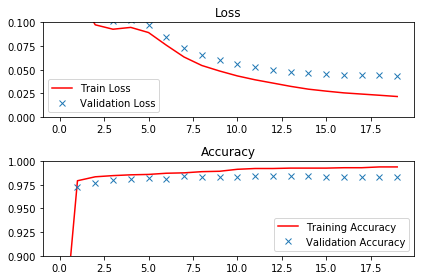

In [197]:
iter_ = len(train_acc_iter)
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(range(iter_), train_loss_iter, 'r', label='Train Loss')
loss_plot.plot(range(iter_), val_loss_iter, 'x', label='Validation Loss')
loss_plot.legend(loc='lower left')
loss_plot.set_ylim([0, 0.1])

acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(range(iter_), train_acc_iter, 'r', label='Training Accuracy')
acc_plot.plot(range(iter_), val_acc_iter, 'x', label='Validation Accuracy')
acc_plot.legend(loc='lower right')
acc_plot.set_ylim([0.9,1.0])
plt.tight_layout()
#plt.savefig('Loss and Accuracy_{}_{}.jpg'.format(feature_extractor, datetime.date.today()), dpi=200)

<a id='Check Point 2'></a>
## Check Point 2

## Generate Test Predictions

In [234]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
import csv
import os
import random

print('All modules are imported.')

All modules are imported.


In [188]:
feature_extractor = 'vgg16_relu6'

folder_name = 'transfer_learning_results/' + feature_extractor

In [189]:
try:
    with open(os.path.join(folder_name, 'test_ids')) as f:
        reader = csv.reader(f, delimiter='\n')
        test_ids = np.array([each for each in reader if len(each) > 0]).squeeze()
    print('Test IDs reloaded from local disk.')
    print("test_ids shape:", test_ids.shape)

except Exception as e:
    print('Unable to reload test ids.')

try:
    with open(os.path.join(folder_name, 'test_codes')) as f:
        test_codes = np.fromfile(f, dtype=np.float32)
        test_codes = test_codes.reshape((len(test_ids), -1))
    print('Test codes are reloaded from local disk.')
    print("test_codes shape:", test_codes.shape)

except Exception as e:
    print('Unable to reload test codes.')

Test IDs reloaded from local disk.
test_ids shape: (12500,)
Test codes are reloaded from local disk.
test_codes shape: (12500, 4096)


In [190]:
def get_test_batches(x, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X = x[ii: ii+batch_size]
        # On the last batch, grab the rest of the data
        else:
            X = x[ii:]
        # I love generators
        yield X

In [208]:
loaded_graph = tf.Graph()
predictions = []
save_model_path = folder_name + '/'

with tf.Session(graph=loaded_graph) as sess:
    #Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)
        
    # Get Tensors from loaded model
    loaded_inputs = loaded_graph.get_tensor_by_name('inputs:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_is_training = loaded_graph.get_tensor_by_name('is_training:0')
    
    for x in get_test_batches(test_codes):
        feed = {loaded_inputs: x,
                loaded_keep_prob: 1.0,
                loaded_is_training: False}
        test_predictions = sess.run(tf.nn.softmax(loaded_logits), feed_dict=feed)
        predictions.append(test_predictions[:,0])
    
    predictions = np.concatenate(predictions)
    
print('Complete predict test image labels.')

INFO:tensorflow:Restoring parameters from transfer_learning_results/vgg16_relu6/
Complete predict test image labels.


Test Image: 6290.jpg
Probability to be dog: 99.97%
Probability to be cat: 0.03%


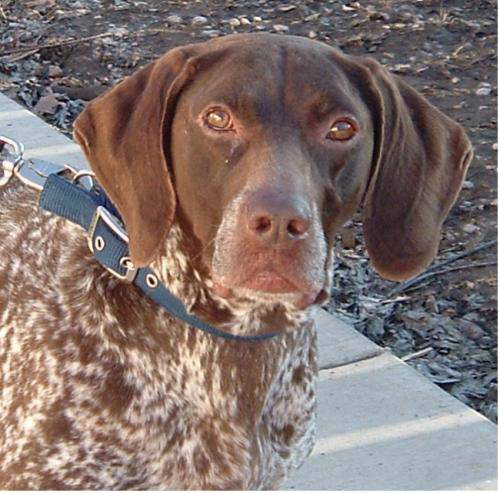

Test Image: 12280.jpg
Probability to be dog: 0.10%
Probability to be cat: 99.90%


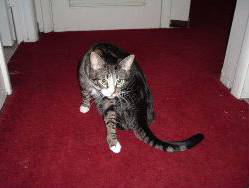

Test Image: 117.jpg
Probability to be dog: 0.12%
Probability to be cat: 99.88%


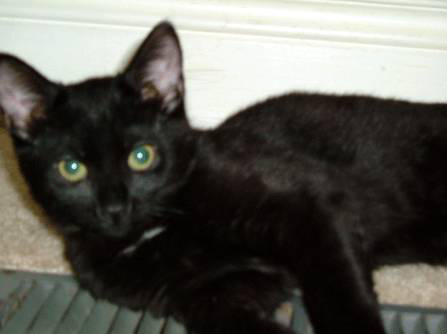

In [237]:
# Randomly choose n_samples test images to test the model accuracy
n_samples = 3

test_seq = random.sample(range(test_codes.shape[0]),n_samples)

for i in test_seq:
    image_id = test_ids[i]
    image_example = cv2.imread('input/test/{}.jpg'.format(image_id), cv2.IMREAD_COLOR)
    print("Test Image: {}.jpg".format(image_id))
    print('Probability to be dog: {:.2f}%'.format(predictions[i]*100))
    print('Probability to be cat: {:.2f}%'.format((1 - predictions[i])*100))
    display(Image.open('input/test/{}.jpg'.format(image_id)))

In [192]:
submissions = {'id': test_ids,
               'label': predictions}
df = pd.DataFrame.from_dict(submissions)
df['id'] = pd.to_numeric(df['id'])
df = df.sort_values(by='id')
df.to_csv(folder_name + '/submission.csv', index=False)